## <font style="color:lightblue">Header</font>

### <font style="color:lightblue">Imports</font>

In [1]:
#%load_ext autoreload
#%autoreload 2

import math
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
import itertools
import random

import sinogap_module as sg




### <font style="color:lightblue">Redefine</font>

In [2]:
sg.plt.rcParams['figure.dpi']=223




### <font style="color:lightblue">Configs</font>

In [3]:
sg.set_seed(7)

sg.TCfg = sg.TCfgClass(
     exec = 3
    ,nofEpochs = None
    ,latentDim = 64
    ,batchSize = 64    #16384 #32768
    ,batchSplit = 1
    ,labelSmoothFac = 0.1 # For Fake labels (or set to 0.0 for no smoothing).
    ,learningRateD = 0.00002
    ,learningRateG = 0.00002
)

sg.DCfg = sg.DCfgClass(16)

#torch.cuda.memory._record_memory_history(device=sg.TCfg.device)
#torch.cuda.memory._dump_snapshot("/data/anton/sinogap/cudaOOM.pickle")
#torch.cuda.memory._record_memory_history(enabled=None)


### <font style="color:lightblue">Raw Read</font>

In [4]:
trainSet = sg.createTrainSet()
prepGdLoss=0
testSet = sg.createTestSet()

Loaded set 19736b.09_Feb.4176862R_Eig_Threshold-4keV
Loaded set 18515.Lamb1_Eiger_7m_45keV_360Scan
Loaded set 23574.8965435L.Eiger.32kev_org
Loaded set 23574.8965435L.Eiger.32kev_sft
Loaded set 18692b_input_PhantomM


### <font style="color:lightblue">Show</font>

7128304
-4.105e-01, 5.013e-03, -4.278e-01, -3.891e-01


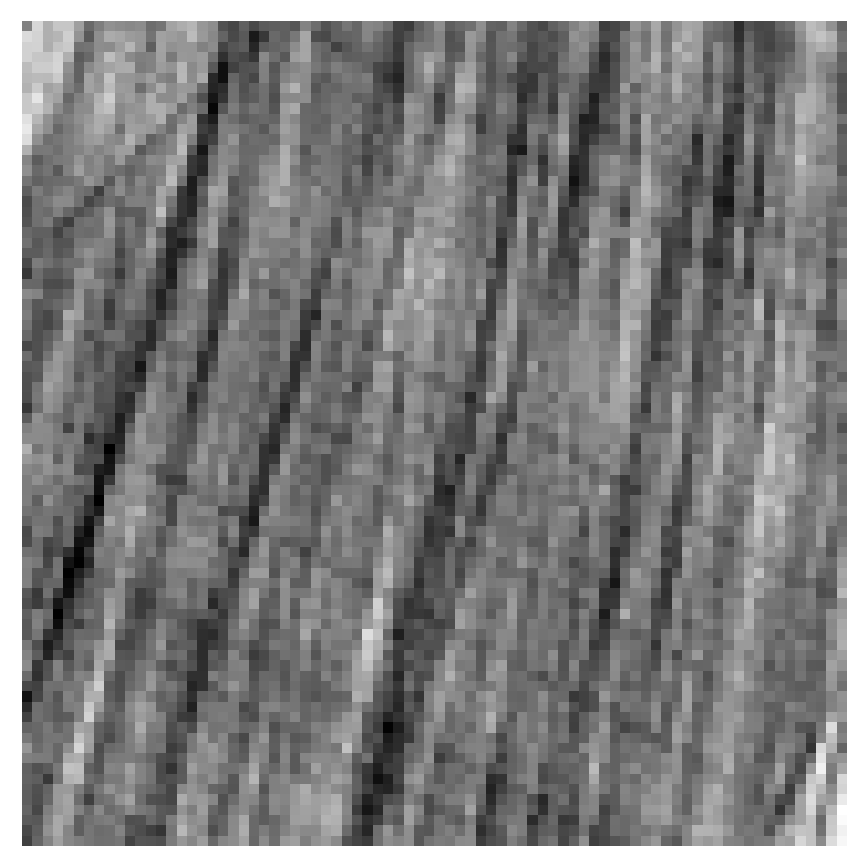

In [5]:
print(len(trainSet))
sg.refImages, sg.refNoises = sg.createReferences(trainSet, 0)
sg.showMe(trainSet, 0 )

## <font style="color:lightblue">Models</font>

### <font style="color:lightblue">Generator</font>

In [6]:


class Generator16(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator16, self).__init__(16,1)

        self.noise2latent = self.createLatent()

        self.encoders =  nn.ModuleList([
            self.encblock( (1+self.latentChannels)/self.baseChannels,
                               1, 3, norm=False),
            self.encblock( 1,  1, 3, dopadding=True),
            self.encblock( 1,  2, 3, stride=2),
            self.encblock( 2,  2, 3, dopadding=True),
            self.encblock( 2,  4, 3, stride=2),
            self.encblock( 4,  4, 3, dopadding=True),
            self.encblock( 4,  8, 3, stride=2),
            self.encblock( 8,  8, 3, dopadding=True),
            self.encblock( 8, 16, 3, stride=2),
            self.encblock(16, 16, 3, dopadding=True),
            ])

        self.fcLink = self.createFClink()

        self.decoders = nn.ModuleList([
            self.decblock(32, 16, 3, dopadding=True),
            self.decblock(32,  8, 4, stride=2),
            self.decblock(16,  8, 3, dopadding=True),
            self.decblock(16,  4, 4, stride=2),
            self.decblock( 8,  4, 3, dopadding=True),
            self.decblock( 8,  2, 4, stride=2),
            self.decblock( 4,  2, 3, dopadding=True),
            self.decblock( 4,  1, 4, stride=2),
            self.decblock( 2,  1, 3, dopadding=True),
            self.decblock( 2,  1, 3, norm=False),
            ])

        self.lastTouch = self.createLastTouch()


sg.generator = Generator16()
sg.generator.to(sg.TCfg.device)
model_summary = summary(sg.generator, input_data=[ [sg.refImages[[0],...], sg.refNoises[[0],...]] ] ).__str__()
print(model_summary)

sg.optimizer_G = sg.createOptimizer(sg.generator, sg.TCfg.learningRateG)





Layer (type:depth-idx)                   Output Shape              Param #
Generator16                              [1, 1, 80, 16]            --
├─Sequential: 1-1                        [1, 1, 80, 80]            --
│    └─Linear: 2-1                       [1, 6400]                 416,000
│    └─ReLU: 2-2                         [1, 6400]                 --
│    └─Unflatten: 2-3                    [1, 1, 80, 80]            --
├─ModuleList: 1-2                        --                        --
│    └─Sequential: 2-4                   [1, 64, 78, 78]           --
│    │    └─Conv2d: 3-1                  [1, 64, 78, 78]           1,216
│    │    └─LeakyReLU: 3-2               [1, 64, 78, 78]           --
│    └─Sequential: 2-5                   [1, 64, 78, 78]           --
│    │    └─Conv2d: 3-3                  [1, 64, 78, 78]           36,928
│    │    └─BatchNorm2d: 3-4             [1, 64, 78, 78]           128
│    │    └─LeakyReLU: 3-5               [1, 64, 78, 78]           --
│ 

### <font style="color:lightblue">Discriminator</font>

In [7]:


class Discriminator(sg.DiscriminatorTemplate):
    def __init__(self):
        super(Discriminator, self).__init__(0)
        self.body =  nn.Sequential(
            self.encblock( 1/self.baseChannels,
                               1, 3, norm=False),
            self.encblock( 1,  1, 3, dopadding=True),
            self.encblock( 1,  2, 3, stride=2),
            self.encblock( 2,  2, 3, dopadding=True),
            self.encblock( 2,  4, 3, stride=2),
            self.encblock( 4,  4, 3, dopadding=True),
            self.encblock( 4,  8, 3, stride=2),
            self.encblock( 8,  8, 3, dopadding=True),
            self.encblock( 8, 16, 3, stride=2),
            self.encblock(16, 16, 3, dopadding=True),
            )
        self.head = self.createHead()




sg.discriminator = Discriminator()
sg.discriminator = sg.discriminator.to(sg.TCfg.device)
model_summary = summary(sg.discriminator, input_data=sg.refImages[0,...] ).__str__()
print(model_summary)
#sg.writer.add_graph(sg.discriminator, refImages)

sg.optimizer_D = sg.createOptimizer(sg.discriminator, sg.TCfg.learningRateD)



Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─Sequential: 1-1                        [1, 1024, 3, 3]           --
│    └─Sequential: 2-1                   [1, 64, 78, 78]           --
│    │    └─Conv2d: 3-1                  [1, 64, 78, 78]           640
│    │    └─LeakyReLU: 3-2               [1, 64, 78, 78]           --
│    └─Sequential: 2-2                   [1, 64, 78, 78]           --
│    │    └─Conv2d: 3-3                  [1, 64, 78, 78]           36,928
│    │    └─BatchNorm2d: 3-4             [1, 64, 78, 78]           128
│    │    └─LeakyReLU: 3-5               [1, 64, 78, 78]           --
│    └─Sequential: 2-3                   [1, 128, 38, 38]          --
│    │    └─Conv2d: 3-6                  [1, 128, 38, 38]          73,856
│    │    └─BatchNorm2d: 3-7             [1, 128, 38, 38]          256
│    │    └─LeakyReLU: 3-8               [1, 128, 38, 38]          --
│   

## <font style="color:lightblue">Restore checkpoint</font>

/home/user/usr/src/sinogap/sinogap_module.py:281: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkPoint = torch.load(path, map_location=TCfg.device)


Probabilities of reference images: Ref: 9.515e-01, Gen: 7.499e-01, Pre: 3.911e-02.
Distances of reference images: REC: 1.998e-01, MSE: 1.998e-01, L1L: 4.386e-01.


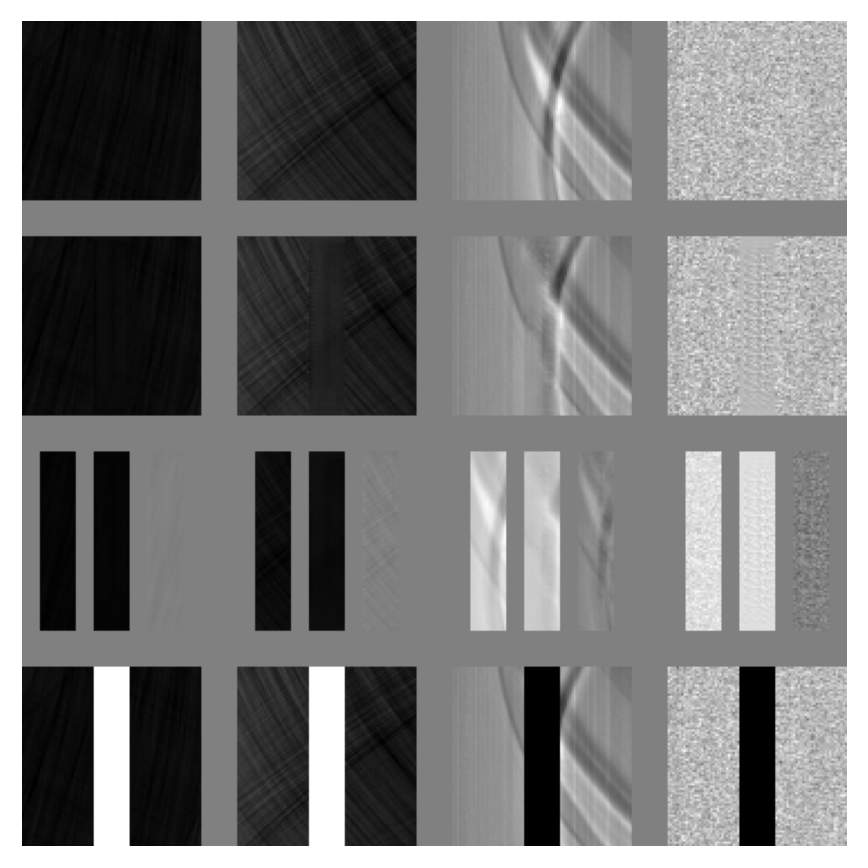

In [8]:
savedCheckPoint = f"checkPoint_{sg.TCfg.exec}"
sg.epoch, sg.iter, sg.minGEpoch, sg.minGdLoss, sg.startFrom = sg.restoreCheckpoint(savedCheckPoint+"_hourly.pth")
sg.writer = sg.createWriter(sg.TCfg.logDir, True)
sg.writer.add_graph(sg.generator, ((sg.refImages, sg.refNoises),) )
#sg.writer.add_graph(sg.discriminator, refImages)
sg.initialTest()

## <font style="color:lightblue">Execute</font>

Epoch: 4 (3).  Dis[0.16]: 0.348 (0.995), Gen[1.00]: 1.784 (0.007), Rec: 2.591e-03 (2.591e-03 / 2.711e-03).
TT: 0.93 (6097863,3104),  FT: 0.20 (6828944,840),  HD: 1.920e-02 (5210738,2977),  GP: 0.012, 0.014 
TF: 0.68 (1925613,546),  FF: 0.11 (1925613,546),  LD: 3.529e-05 (6381665,2668),  R : 0.020.


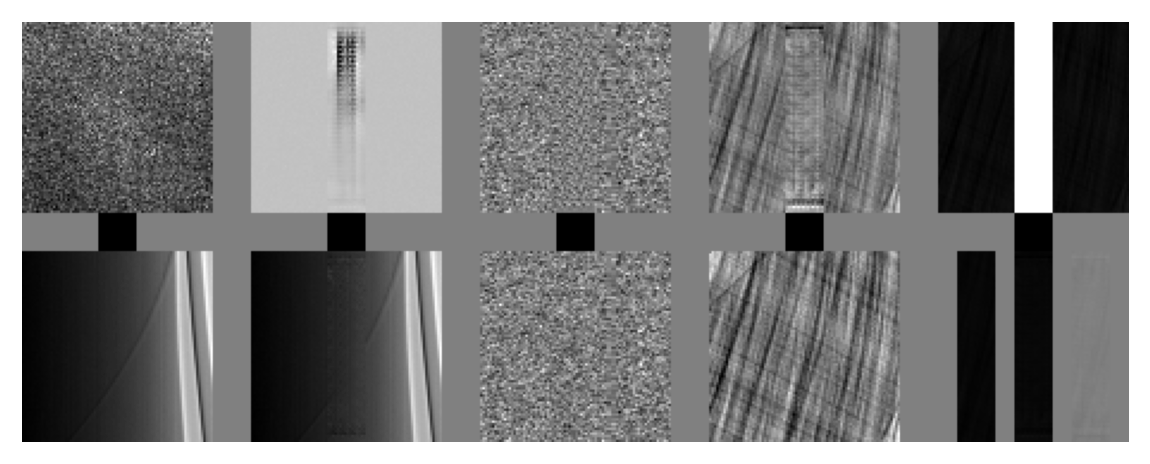

 53%|█████▎    | 59257/111379 [51:06<6:35:26,  2.20it/s]

In [ ]:

#torch.autograd.set_detect_anomaly(True)
#sg.TCfg.batchSize = 64
sg.dataLoader = sg.createTrainLoader(trainSet, num_workers=8)
sg.testLoader = sg.createTestLoader(testSet, num_workers=8)
#Rec_diff, MSE_diff, L1L_diff = sg.summarizeSet(sg.testLoader)
##Summary. Rec: 2.203e-03, MSE: 2.203e-03, L1L: 1.882e-02.
#sg.writer.add_scalars("Test per epoch",
#                   {'MSE': MSE_diff
#                   ,'L1L': L1L_diff
#                   ,'REC': Rec_diff
#                   }, 0 )
#Rec_diff, MSE_diff, L1L_diff = sg.summarizeSet(sg.testLoader, False)
##Summary. Rec: 2.190e-03, MSE: 2.190e-03, L1L: 1.854e-02
#sg.writer.add_scalars("Test per epoch",
#                   {'MSE': MSE_diff
#                   ,'L1L': L1L_diff
#                   ,'REC': Rec_diff
#                   }, sg.epoch )

#torch.autograd.set_detect_anomaly(True)
#Summary. Rec: 2.711e-03, MSE: 2.711e-03, L1L: 3.165e-02.
Rec_diff, MSE_diff, L1L_diff = 2.711e-03, 2.711e-03, 3.165e-02
sg.prepGdLoss =  Rec_diff
if Rec_diff == 0:
    Rec_diff, MSE_diff, L1L_diff = sg.summarizeSet(sg.dataLoader)
if not sg.epoch :
    sg.writer.add_scalars("Distances per epoch",
                          {'MSE': MSE_diff
                          ,'L1L': L1L_diff
                          ,'REC': Rec_diff
                          }, 0 )

sg.lossDifCoef = 256
sg.noAdv = False
sg.lossAdvCoef = 1.0

try :
    sg.train(savedCheckPoint)
except :
    sg.epoch -= 1
    del sg.dataLoader
    del sg.testLoader
    sg.freeGPUmem()
    1/10 # to release Jupyuter memory in the next step
    raise


 # adv, no preProc

## <font style="color:lightblue">Post</font>

In [ ]:
sg.initialTest()


In [ ]:
sg.testMe(trainSet, 5)

### <font style="color:lightblue">Save results</font>

In [ ]:
sg.saveModels()